In [ ]:
import torch
print(torch.__version__)

2.5.1+cu121


In [ ]:
!python --version

Python 3.10.12


In [ ]:
!rm -rf /content/bert_imb

# <font color = 'indianred'>**Multilabel Classification of StackExchange Dataset using GEMMA** </font>

**Objective:**

In this notebook, we aim to use GEMMA models with QLORA for classification problems. **We will now use Casual Languagge Model - Basically we will do instruction tuning.**


**Plan**

1. Set Environment
2. Load Dataset
3. Accessing and Manipulating Splits
4. Load Pre-trained Tokenizer
5. Create Prompts
6. Model Training
  1. Download pre-trained model <br>  
  3. PEFT Setup
  4. Training Arguments <br>
  5. Instantiate Trainer <br>
  6. Setup WandB <br>
  7. Training
  8. Validation
7. Perfromance on Test Set
8. Model Inference






















# <font color = 'indianred'> **1. Setting up the Environment** </font>



In [ ]:
# If in Colab, then import the drive module from google.colab
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  # Mount the Google Drive to access files stored there
  drive.mount('/content/drive')

  # Install the latest version of torchtext library quietly without showing output
  # !pip install torchtext -qq
  !pip install transformers evaluate wandb datasets accelerate peft bitsandbytes trl -U  -qq ## NEW LINES ##
  basepath = '/content/drive/MyDrive/data/'
else:
  basepath = '/home/harpreet/Insync/google_drive_shaannorr/data'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<font color = 'indianred'> *Load Libraries* </font>

In [ ]:
# standard data science librraies for data handling and v isualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re
import gc
import time

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, precision_score, recall_score, f1_score
import joblib

import torch
import torch.nn as nn
import ast


# New libraries introduced in this notebook
import evaluate
from datasets import load_dataset, DatasetDict, Dataset, ClassLabel
from trl import SFTConfig, SFTTrainer, DataCollatorForCompletionOnlyLM
from transformers import (
    TrainingArguments,
    Trainer,
    set_seed,
    AutoTokenizer,
    AutoModelForCausalLM,
    DataCollatorForLanguageModeling,
    AutoConfig,
    pipeline,
    BitsAndBytesConfig,
)
from peft import (
    TaskType,
    LoraConfig,
    prepare_model_for_kbit_training,
    get_peft_model,
)

import wandb
from google.colab import userdata
from huggingface_hub import login


In [ ]:
set_seed(42)

In [ ]:
wandb_api_key = userdata.get('WANDB_API_KEY')
hf_token = userdata.get('HF_TOKEN')


In [ ]:
if hf_token:
    # Log in to Hugging Face
    login(token=hf_token)
    print("Successfully logged in to Hugging Face!")
else:
    print("Hugging Face token not found in notebook secrets.")


Successfully logged in to Hugging Face!


In [ ]:
if wandb_api_key:
  wandb.login(key=wandb_api_key)
  print("Successfully logged in to WANDB!")
else:
    print("WANDB key not found in notebook secrets.")


wandb: Currently logged in as: hsingh-utd. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Successfully logged in to WANDB!


In [ ]:
# CHANGE FOLDERS TO WHERE YOU WANT TO SAVE DATA AND MODELS
base_folder = Path(basepath)
data_folder = base_folder/'datasets/Classification_HW/joblib_files'

# <font color = 'indianred'> **2. Load Data set**
    


In [ ]:
df = joblib.load(data_folder/'df_multilabel_hw_cleaned.joblib')
df

,cleaned_text,Tags,Tag_Number
0,asp query stre dropdown webpage follow control...,c# asp.net,"[0, 9]"
1,run javascript code server java code want run ...,java javascript,"[1, 3]"
2,linq sql throw exception row find change hi li...,c# asp.net,"[0, 9]"
3,run python script php server run nginx web ser...,php python,"[2, 7]"
4,advice write function m try write function res...,javascript jquery,"[3, 5]"
...,...,...,...
47422,take value edittext put decimal point all- wor...,java android,"[1, 4]"
47423,listen phone state application nee liste phone...,java android,"[1, 4]"
47424,android ui thread thread task want access main...,java android,"[1, 4]"
47425,dynamic table row creation html javascript htm...,asp.net javascript,"[9, 3]"


In [ ]:
stack_dataset = Dataset.from_pandas(df)

In [ ]:
selected_columns = {
    'text': stack_dataset['cleaned_text'],
    'tag': stack_dataset['Tags']
}

# Create a new dataset with the selected columns
stack_selected_columns = Dataset.from_dict(selected_columns)

In [ ]:
stack_selected_columns

Dataset({
    features: ['text', 'tag'],
    num_rows: 47427
})

In [ ]:
stack_selected_columns['tag'][0]

'c# asp.net'

In [ ]:
# Set the format to Pandas
stack_selected_columns.set_format(type='pandas')

In [ ]:
df = stack_selected_columns[:]

In [ ]:
# Remove existing quotes first (if any) and then add just one set
import json
df['label'] = df['tag'].str.split().apply(lambda x: json.dumps([tag.strip() for tag in x]))


In [ ]:
df

,text,tag,label
0,asp query stre dropdown webpage follow control...,c# asp.net,"[""c#"", ""asp.net""]"
1,run javascript code server java code want run ...,java javascript,"[""java"", ""javascript""]"
2,linq sql throw exception row find change hi li...,c# asp.net,"[""c#"", ""asp.net""]"
3,run python script php server run nginx web ser...,php python,"[""php"", ""python""]"
4,advice write function m try write function res...,javascript jquery,"[""javascript"", ""jquery""]"
...,...,...,...
47422,take value edittext put decimal point all- wor...,java android,"[""java"", ""android""]"
47423,listen phone state application nee liste phone...,java android,"[""java"", ""android""]"
47424,android ui thread thread task want access main...,java android,"[""java"", ""android""]"
47425,dynamic table row creation html javascript htm...,asp.net javascript,"[""asp.net"", ""javascript""]"


In [ ]:
df_final = df[['text', 'label']]

In [ ]:
df_final

,text,label
0,asp query stre dropdown webpage follow control...,"[""c#"", ""asp.net""]"
1,run javascript code server java code want run ...,"[""java"", ""javascript""]"
2,linq sql throw exception row find change hi li...,"[""c#"", ""asp.net""]"
3,run python script php server run nginx web ser...,"[""php"", ""python""]"
4,advice write function m try write function res...,"[""javascript"", ""jquery""]"
...,...,...
47422,take value edittext put decimal point all- wor...,"[""java"", ""android""]"
47423,listen phone state application nee liste phone...,"[""java"", ""android""]"
47424,android ui thread thread task want access main...,"[""java"", ""android""]"
47425,dynamic table row creation html javascript htm...,"[""asp.net"", ""javascript""]"


In [ ]:
class_names = ['c#', 'java', 'php','javascript', 'android', 'jquery', 'c++',  'python', 'iphone', 'asp.net']

In [ ]:
stack_selected_columns_final = Dataset.from_pandas(df_final)

In [ ]:
stack_selected_columns_final[0]['label']

'["c#", "asp.net"]'

# <font color = 'indianred'> **3. Accessing and Manuplating Splits**</font>



<font color = 'indianred'>*Create futher subdivions of the splits*</font>

In [ ]:
# Split the test set into test and validation sets
test_val_splits = stack_selected_columns_final.train_test_split(test_size=0.4, seed=42)
train_split= test_val_splits['train']
test_val_splits = test_val_splits['test'].train_test_split(test_size=0.5, seed=42,)
val_split = test_val_splits['train']
test_split = test_val_splits['test']


<font color = 'indianred'>*small subset for initial experimenttaion*</font>

In [ ]:
train_split = train_split.shuffle(seed = 42).select(range(2000))
val_split = val_split.shuffle(seed = 42).select(range(2000))
test_split = test_split.shuffle(seed = 42).select(range(2000))

In [ ]:
train_val_subset= DatasetDict(
    {"train": train_split, "valid": val_split})

In [ ]:
train_val_subset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [ ]:
train_val_subset['train']['label'][0]

'["javascript", "jquery"]'

# <font color = 'indianred'>**4. Load pre-trained Tokenizer**</font>



In [ ]:
def free_gpu_memory():
    """
    Frees up GPU memory after CUDA out-of-memory error in Colab.

    This function performs the following steps:
    1. Deletes all PyTorch objects to clear references.
    2. Calls garbage collection to remove unreferenced objects from memory.
    3. Uses torch.cuda.empty_cache() to release cached GPU memory.
    4. Waits for a moment to ensure memory is fully released.
    """
    try:
        # Delete all torch tensors to free up memory
        for obj in list(locals().values()):
            if torch.is_tensor(obj):
                del obj

        # Collect garbage to release any remaining unused memory
        gc.collect()

        # Empty the CUDA cache to release GPU memory
        torch.cuda.empty_cache()

        # Adding a small delay to allow memory to be fully released
        time.sleep(2)

        print("GPU memory has been freed.")
    except Exception as e:
        print(f"Error while freeing GPU memory: {e}")


In [ ]:
free_gpu_memory()

GPU memory has been freed.


In [ ]:
checkpoint = "google/gemma-2-2b"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [ ]:
tokenizer.eos_token

'<eos>'

#<font color = 'indianred'> **5. Create Prompts**



In [ ]:
def formatting_prompts_func(examples, input_field, output_field, prompt_template, output_delimiter, tokenizer, include_eos_token=True):
    """Format a single example or batch of examples"""
    # Debug the input type
    # print("Input type:", type(examples))
    # print("Input content:", examples)

    # Convert to dict if it's a LazyRow
    if hasattr(examples, 'keys'):
        examples = dict(examples)

    # Handle single example case (for dataset.map)
    if isinstance(examples, dict):
        if not isinstance(examples[input_field], (list, tuple)):
            input_text = examples[input_field].strip()
            output_text = examples[output_field]
            output_delimiter = output_delimiter.strip()

            prompt = prompt_template.format(input_text, output_delimiter, output_text)

            if include_eos_token:
                prompt = prompt + tokenizer.eos_token

            return prompt.strip()
        else:
            # Handle batch case
            output_prompts = []
            for i in range(len(examples[input_field])):
                input_text = examples[input_field][i].strip()
                output_text = examples[output_field][i]
                output_delimiter = output_delimiter.strip()

                prompt = prompt_template.format(input_text, output_delimiter, output_text)

                if include_eos_token:
                    prompt = prompt + tokenizer.eos_token
                prompt = prompt.strip()
                output_prompts.append(prompt)

            return output_prompts

    print("Unexpected input format!")
    print("Type:", type(examples))
    print("Content:", examples)
    raise ValueError(f"Expected a dictionary with examples, got {type(examples)}")


In [ ]:
prompt_template = 'Classify the TEXT by selecting all applicable labels from the following list: \
["android", "asp.net", "c#", "c++", "iphone", "java", "javascript", "jquery", "php", "python"].\
 ### TEXT: {} {} {}'

In [ ]:
output_delimiter = "### LABEL:"
input_field = 'text'
output_field = 'label'

In [ ]:
output_delimiter

'### LABEL:'

In [ ]:
from functools import partial

In [ ]:
formatting_prompts_func_final = partial(formatting_prompts_func,
                                        input_field =input_field,
                                        output_field = output_field,
                                        prompt_template=prompt_template,
                                        output_delimiter=output_delimiter,
                                        tokenizer=tokenizer
)

In [ ]:
samples = formatting_prompts_func_final(train_val_subset['train'][0:3])

In [ ]:
from pprint import pprint
pprint(samples[0], width=120)

('Classify the TEXT by selecting all applicable labels from the following list: ["android", "asp.net", "c#", "c++", '
 '"iphone", "java", "javascript", "jquery", "php", "python"]. ### TEXT: edit link place use javascript edit text place '
 'need edit link click link instead make editable redirect link address change double click link editable redirect '
 'help ### LABEL: ["javascript", "jquery"]<eos>')


In [ ]:
single_sample = formatting_prompts_func_final(train_val_subset['train'][0])
pprint(single_sample, width=120)

('Classify the TEXT by selecting all applicable labels from the following list: ["android", "asp.net", "c#", "c++", '
 '"iphone", "java", "javascript", "jquery", "php", "python"]. ### TEXT: edit link place use javascript edit text place '
 'need edit link click link instead make editable redirect link address change double click link editable redirect '
 'help ### LABEL: ["javascript", "jquery"]<eos>')


##  <font color = 'indianred'> **5.1 Filter Longer sequences**

In [ ]:
def filter_by_length(example, max_length, tokenizer, prompt_function):
    """Filter a single example based on length"""
    # Convert LazyRow to dict if needed
    example_dict = dict(example) if hasattr(example, 'keys') else example

    prompt = prompt_function(example_dict)  # handles single example
    tokenized_prompt = tokenizer(prompt, add_special_tokens=False, truncation=False, padding=False)
    total_length = len(tokenized_prompt['input_ids'])
    example['keep'] = total_length <= max_length
    return example

# Create partial function
filter_fn = partial(filter_by_length,0
                   max_length=1000,
                   tokenizer=tokenizer,
                   prompt_function=formatting_prompts_func_final)

# Now try processing the dataset
train_val_subset = train_val_subset.map(filter_fn, desc="Processing dataset")

Processing dataset:   0%|          | 0/2000 [00:00<?, ? examples/s]

Processing dataset:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
train_val_subset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'keep'],
        num_rows: 2000
    })
    valid: Dataset({
        features: ['text', 'label', 'keep'],
        num_rows: 2000
    })
})

In [ ]:
train_val_subset_filtered = train_val_subset.filter(lambda x: x['keep']).remove_columns(['keep'])

Filter:   0%|          | 0/2000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
train_val_subset_filtered

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1954
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 1960
    })
})

##  <font color = 'indianred'> **5.2 Data Collator**

In [ ]:
def get_token_ids_in_context(tokenizer, full_string, substring):
    # Tokenize the full string
    full_tokens = tokenizer.encode(full_string, add_special_tokens=False)

    # Find the start and end indices of the substring in the full string
    start_index = full_string.index(substring)
    end_index = start_index + len(substring)

    # Find the corresponding tokens, starting one token earlier
    start_token_index = max(0, len(tokenizer.encode(full_string[:start_index], add_special_tokens=False)) - 1)
    end_token_index = len(tokenizer.encode(full_string[:end_index], add_special_tokens=False))

    return full_tokens[start_token_index:end_token_index]

In [ ]:
# Create a sample prompt format
sample_prompt_format = "some text {} {} {}"

# Create a sample prompt
sample_prompt = sample_prompt_format.format("input", output_delimiter, "output")

output_delimiter_ids = get_token_ids_in_context(tokenizer, full_string=sample_prompt, substring=output_delimiter )

# Print debug information
print('Original output_delimiter:', output_delimiter)
print('output_delimiter_ids:', output_delimiter_ids)
print('Delimiter tokens:', tokenizer.convert_ids_to_tokens(output_delimiter_ids))
print('Reconstructed output_delimiter:', tokenizer.decode(output_delimiter_ids))

Original output_delimiter: ### LABEL:
output_delimiter_ids: [43774, 35390, 235292]
Delimiter tokens: ['▁###', '▁LABEL', ':']
Reconstructed output_delimiter:  ### LABEL:


In [ ]:
data_collator_comp = DataCollatorForCompletionOnlyLM(tokenizer=tokenizer, mlm=False,
                                                      response_template=output_delimiter_ids)

#  <font color = 'indianred'> **6. Model Training**

##  <font color = 'indianred'> **6.1 Download pre-trained model**

In [ ]:
def get_appropriate_dtype():
    if torch.cuda.is_available() and torch.cuda.get_device_capability(0) >= (8, 0):
        return torch.bfloat16
    return torch.float16

In [ ]:
torch_data_type = get_appropriate_dtype()
torch_data_type

torch.bfloat16

In [ ]:
bnb_config = BitsAndBytesConfig(
  load_in_4bit=True,
  bnb_4bit_quant_type="nf4",
  bnb_4bit_use_double_quant=True,
  bnb_4bit_compute_dtype=torch_data_type,
  bnb_4bit_quant_storage=torch_data_type,
)

In [ ]:
model = AutoModelForCausalLM.from_pretrained(checkpoint,
                                             quantization_config=bnb_config,
                                             torch_dtype=torch_data_type,
                                             trust_remote_code=True,)


`low_cpu_mem_usage` was None, now default to True since model is quantized.


model-00001-of-00003.safetensors:  97%|#########6| 4.83G/4.99G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/481M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

##  <font color = 'indianred'> **6.2 PEFT Setup**

In [ ]:
model

Gemma2ForCausalLM(
  (model): Gemma2Model(
    (embed_tokens): Embedding(256000, 2304, padding_idx=0)
    (layers): ModuleList(
      (0-25): 26 x Gemma2DecoderLayer(
        (self_attn): Gemma2Attention(
          (q_proj): Linear4bit(in_features=2304, out_features=2048, bias=False)
          (k_proj): Linear4bit(in_features=2304, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=2304, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=2048, out_features=2304, bias=False)
          (rotary_emb): Gemma2RotaryEmbedding()
        )
        (mlp): Gemma2MLP(
          (gate_proj): Linear4bit(in_features=2304, out_features=9216, bias=False)
          (up_proj): Linear4bit(in_features=2304, out_features=9216, bias=False)
          (down_proj): Linear4bit(in_features=9216, out_features=2304, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): Gemma2RMSNorm((2304,), eps=1e-06)
        (pre_feedforward_layernorm)

In [ ]:
def find_linear_layers(model):
    """
    Extracts the unique names of Linear layers from a model.

    Args:
    model (nn.Module): The model from which to extract Linear layer names.

    Returns:
    list: A list of unique names of Linear layers.
    """
    # Convert the model's modules to string
    model_modules = str(model.modules)
    # Pattern to extract names of Linear layers
    pattern = r'\((\w+)\): Linear'
    # Find all occurrences of the pattern
    linear_layer_names = re.findall(pattern, model_modules)
    print(linear_layer_names)
    # Get unique names using a set, then convert back to list
    target_modules = list(set(linear_layer_names))
    return target_modules

In [ ]:
find_linear_layers(model)

['q_proj', 'k_proj', 'v_proj', 'o_proj', 'gate_proj', 'up_proj', 'down_proj', 'lm_head']


['o_proj',
 'lm_head',
 'v_proj',
 'q_proj',
 'k_proj',
 'up_proj',
 'down_proj',
 'gate_proj']

In [ ]:
TaskType.CAUSAL_LM

<TaskType.CAUSAL_LM: 'CAUSAL_LM'>

In [ ]:
peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    r=128,
    lora_alpha=256,
    lora_dropout=0.01,
    target_modules = ['v_proj',  'q_proj',  'up_proj', 'o_proj', 'down_proj', 'gate_proj','k_proj'])

lora_model = get_peft_model(model, peft_config )
# qlora_model.resize_token_embeddings(len(tokenizer))
lora_model.print_trainable_parameters()

trainable params: 166,133,760 || all params: 2,780,475,648 || trainable%: 5.9750


## <font color = 'indianred'> **6.3 Training Arguments**</font>







In [ ]:
# Define the directory where model checkpoints will be saved
model_folder = base_folder/'models/gemma_qlora_lmh'

# Create the directory if it doesn't exist
model_folder.mkdir(exist_ok=True, parents=True)
run_name= 'stack_exp_lmh_gemma'

use_fp16 = torch_data_type == torch.float16
use_bf16 = torch_data_type == torch.bfloat16

# Configure training parameters
training_args = SFTConfig(
    seed = 42,
    # Training-specific configurations
    num_train_epochs=2,  # Total number of training epochs
    # Number of samples per training batch for each device
    per_device_train_batch_size=4,
    # Number of samples per evaluation batch for each device
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=8,
    gradient_checkpointing=True,
    gradient_checkpointing_kwargs={"use_reentrant":False},
    # torch_empty_cache_steps=5,
    weight_decay=0.0,  # Apply L2 regularization to prevent overfitting
    learning_rate=1e-5,  # Step size for the optimizer during training
    optim='adamw_torch',  # Optimizer,

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    eval_strategy='steps',  # Evaluate model at specified step intervals
    eval_steps=20,  # Perform evaluation every 10 training steps
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=20,  # Save a model checkpoint every 10 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints
    # Use 'accuracy' as the metric to determine the best model
    metric_for_best_model="eval_loss",
    greater_is_better=False,  # A model is 'better' if its accuracy is higher


    # Experiment logging configurations (commented out in this example)
    logging_strategy='steps',
    logging_steps=20,
    report_to='wandb',  # Log metrics and results to Weights & Biases platform
    run_name= run_name,  # Experiment name for Weights & Biases

    # Precision settings determined based on GPU capability
    fp16=use_fp16 ,  # Set True if torch_data_type is torch.float16
    bf16=use_bf16,  # Set True if torch_data_type is torch.bfloat16
    tf32=False,  # Disable tf32 unless you want to use Ampere specific optimization
)


In [ ]:
# If gradient checkpointing is enabled, configure relevant settings
if training_args.gradient_checkpointing:
    model.config.use_cache = False  # Disable caching for compatibility

model.config

Gemma2Config {
  "_attn_implementation_autoset": true,
  "_name_or_path": "google/gemma-2-2b",
  "architectures": [
    "Gemma2ForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "attn_logit_softcapping": 50.0,
  "bos_token_id": 2,
  "cache_implementation": "hybrid",
  "eos_token_id": 1,
  "final_logit_softcapping": 30.0,
  "head_dim": 256,
  "hidden_act": "gelu_pytorch_tanh",
  "hidden_activation": "gelu_pytorch_tanh",
  "hidden_size": 2304,
  "initializer_range": 0.02,
  "intermediate_size": 9216,
  "max_position_embeddings": 8192,
  "model_type": "gemma2",
  "num_attention_heads": 8,
  "num_hidden_layers": 26,
  "num_key_value_heads": 4,
  "pad_token_id": 0,
  "quantization_config": {
    "_load_in_4bit": true,
    "_load_in_8bit": false,
    "bnb_4bit_compute_dtype": "bfloat16",
    "bnb_4bit_quant_storage": "bfloat16",
    "bnb_4bit_quant_type": "nf4",
    "bnb_4bit_use_double_quant": true,
    "llm_int8_enable_fp32_cpu_offload": false,
    "llm_int8_has_fp1

##  <font color = 'indianred'> **6.4 Initialize Trainer**</font>



In [ ]:
# lora_model.config.use_cache = False
trainer = SFTTrainer(
        model=model,
        tokenizer=tokenizer,
        args=training_args,
        train_dataset=train_val_subset_filtered['train'],
        eval_dataset=train_val_subset_filtered['valid'],
        peft_config=peft_config,
        formatting_func =  formatting_prompts_func_final,
        data_collator=data_collator_comp,)

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:309: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/1954 [00:00<?, ? examples/s]

Map:   0%|          | 0/1960 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:403: UserWarning: You passed a processing_class with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `processing_class.padding_side = 'right'` to your code.
  warnings.warn(


## <font color = 'indianred'> **6.5 Setup WandB**</font>

In [ ]:
%env WANDB_PROJECT = multilabel_stack

env: WANDB_PROJECT=multilabel_stack


##  <font color = 'indianred'> **6.7 Training**

In [ ]:
try:
    # Your code that may cause a CUDA out-of-memory error
    # Example: trainer.train() or other GPU intensive operations
    # lora_model.config.use_cache = False
    trainer.train()
except RuntimeError as e:
    if 'CUDA out of memory' in str(e):
        print("CUDA out of memory error detected. Freeing GPU memory.")
        free_gpu_memory()
        # Optionally, you can retry the operation here after freeing up memory
        # Example retry:
        # trainer.train()
    else:
        raise e


Step,Training Loss,Validation Loss
20,0.328300,0.136625
40,0.125700,0.107176
60,0.113800,0.102597
80,0.083100,0.099531
100,0.077900,0.096625
120,0.067000,0.094266


In [ ]:
best_model_checkpoint_step = trainer.state.best_model_checkpoint.split('-')[-1]

In [ ]:
best_model_checkpoint_step

'120'

##  <font color = 'indianred'> **6.8 Validation**

<font color = 'indianred'> *Evaluate model on Validation Set* </font>


In [ ]:
model_folder = base_folder/'models/gemma_qlora_lmh'
best_model_checkpoint_step
checkpoint = str(model_folder/f'checkpoint-{best_model_checkpoint_step}')
checkpoint

'/content/drive/MyDrive/data/models/gemma_qlora_lmh/checkpoint-120'

In [ ]:
from peft import AutoPeftModelForCausalLM, PeftConfig

In [ ]:
model = AutoPeftModelForCausalLM.from_pretrained(checkpoint,
                                             quantization_config=bnb_config,
                                             torch_dtype=torch_data_type,
                                             trust_remote_code=True,
                                             device_map='auto')

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
model.device

device(type='cuda', index=0)

In [ ]:
peft_config = PeftConfig.from_pretrained(checkpoint)
base_model_name = peft_config.base_model_name_or_path
tokenizer = AutoTokenizer.from_pretrained(base_model_name)

In [ ]:
print(output_delimiter)

### LABEL:


In [ ]:
def extract_content(generated_text, output_delimiter=output_delimiter):
    # Get everything after the output_delimiter (e.g., "### LABEL:")
    pattern = f'{re.escape(output_delimiter.strip())}\\s*(.*)'
    # print(pattern)
    # print(output_delimiter)

    match = re.search(pattern, generated_text, re.DOTALL)
    if match:
        content = match.group(1).strip()
        try:
            # If it's a tuple format with space-separated strings
            if content.startswith('(') and content.endswith(')') and ' ' in content:
                # Remove parentheses and split by spaces
                content = content[1:-1]  # Remove outer parentheses
                # Split by space and clean up quotes
                labels = [label.strip('"').strip("'") for label in content.split()]
                return ' '.join(labels)

            # Try regular ast.literal_eval for other cases
            parsed_content = ast.literal_eval(content)
            if isinstance(parsed_content, (int, float)):
                print(f"Warning: Numeric output detected: {parsed_content}")
                return str(parsed_content)  # Convert to string for consistency
            return parsed_content
        except:
            return content
    else:
        print(f"No content found after '{output_delimiter}'.")
        return None

# Test cases
test_cases = [
    "Here's some text ### LABEL: ['java', 'android']",
    "Process text ### LABEL: ('java', 'android')",
    "Calculate ### LABEL: 42",
    "Classify the TEXT by selecting all applicable labels from the following list: ['android', 'java']. ### TEXT: some text ### LABEL: ('java' 'android')"
]

for test in test_cases:
    print("\nInput:", test)
    print("Output:", extract_content(test))


Input: Here's some text ### LABEL: ['java', 'android']
Output: ['java', 'android']

Input: Process text ### LABEL: ('java', 'android')
Output: java', android

Input: Calculate ### LABEL: 42
Output: 42

Input: Classify the TEXT by selecting all applicable labels from the following list: ['android', 'java']. ### TEXT: some text ### LABEL: ('java' 'android')
Output: java android


In [ ]:
from tqdm import tqdm
import itertools



def run_inference(seed, dataset, model, tokenizer, per_device_batch_size, prompt_template, input_field, output_field, output_delimiter,
                  max_new_tokens=10,num_beams=1, do_sample=False,top_k=50,top_p=1, temperature=1.0, no_repeat_ngram_size =2,
                  num_return_sequences=1  ):
        set_seed(seed)
        model.eval()
        print(f"Model device for inference: {model.device}")
        device = model.device
        batch_size = per_device_batch_size

        responses = []
        extracted_outputs = []

        # Determine the total number of items and create an appropriate iterator
        if isinstance(dataset, dict):
            total_items = len(next(iter(dataset.values())))
            data_iterator = (dict(zip(dataset.keys(), values)) for values in zip(*dataset.values()))
        else:
            total_items = len(dataset)
            data_iterator = dataset

        progress_bar = tqdm(range(0, total_items, batch_size), desc="Generating responses")

        for i in progress_bar:
            # Create a batch
            batch = list(itertools.islice(data_iterator, i, i + batch_size))

            try:
                if isinstance(batch[0], dict):
                    prompts = [
                        prompt_template.format(
                            item[input_field].strip(),
                            output_delimiter.strip(),
                            ""
                        ).strip() for item in batch
                    ]
                elif isinstance(batch[0], str):
                    prompts = [
                        prompt_template.format(
                            item.strip(),
                            output_delimiter.strip(),
                            ""
                        ).strip() for item in batch
                    ]
                else:
                    raise ValueError(f"Unexpected item type in batch: {type(batch[0])}")

                inputs = tokenizer(prompts, return_tensors="pt", padding=True)
                inputs = {k: v.to(device) for k, v in inputs.items()}

                with torch.no_grad():
                    outputs = model.generate(
                        **inputs,
                        max_new_tokens=max_new_tokens,
                        num_beams=num_beams,
                        do_sample=do_sample,
                        top_k=top_k,
                        top_p=top_p,
                        temperature=temperature,
                        no_repeat_ngram_size=no_repeat_ngram_size,
                        num_return_sequences=num_return_sequences,
                        pad_token_id=tokenizer.pad_token_id,
                    )

                decoded_outputs = tokenizer.batch_decode(outputs, skip_special_tokens=True)

                for item, decoded_output in zip(batch, decoded_outputs):
                    extracted_output = extract_content(decoded_output, output_delimiter)

                    if isinstance(item, dict):
                        input_text = item[input_field]
                        true_output = item.get(output_field, "N/A")
                    else:
                        input_text = item
                        true_output = "N/A"

                    responses.append({
                        "input": input_text,
                        "generated_output": decoded_output,
                        "true_output": true_output
                    })
                    extracted_outputs.append({
                        "input": input_text,
                        "extracted_output": extracted_output,
                        "true_output": true_output
                    })


            except Exception as e:
                print(f"Error processing batch: {str(e)}")
                print(f"Problematic batch: {batch}")
                continue

        return responses, extracted_outputs

In [ ]:
free_gpu_memory()

GPU memory has been freed.


In [ ]:
valid_responses, valid_extracted_outputs= run_inference(seed = 42,
              dataset=train_val_subset_filtered['valid'],
              model=model,
              tokenizer=tokenizer,
              per_device_batch_size=50,
              prompt_template=prompt_template,
              input_field=input_field,
              output_field=output_field,
              output_delimiter=output_delimiter)

Model device for inference: cuda:0


Generating responses: 100%|██████████| 40/40 [03:18<00:00,  4.95s/it]


In [ ]:
valid_responses[0]['generated_output']

'Classify the TEXT by selecting all applicable labels from the following list: ["android", "asp.net", "c#", "c++", "iphone", "java", "javascript", "jquery", "php", "python"]. ### TEXT: seperate jquery script selector external file work jquery selector event associate want external file copy directly save thing external javascript selector work explain note able use function html file externalize work script follows:-   $ pervious\').click(function          var presentslide = $ .visible\').attr(\'id          var temparr = presentslide.split("-          var persentslideno = temparr[1          var perviousslideno = number(persentslideno 1 perviousslideno > -1                    var perviousslide = slide- + perviousslideno               $ + presentslide).fadeout(\'slow\',function              $ this).removeclass(\'visible\').addclass(\'hidden                           $ + perviousslide).fadein(\'slow\',function              $ this).removeclass(\'hidden\').addclass(\'visible ### LABEL:(["ja

In [ ]:
valid_extracted_outputs[0]['extracted_output']

['javascript', 'jquery']

In [ ]:
for i in range(10):
  print(valid_extracted_outputs[i]['extracted_output'])

['javascript', 'jquery']
=["javascript","jquery"]
java android
java android
['c#vb.NET']
['javascript', 'jquery']
=["javascript","jquery"]
[c#, asp.
['java', 'android']
javascript  jquery


In [ ]:
valid_responses[1]['generated_output']

'Classify the TEXT by selecting all applicable labels from the following list: ["android", "asp.net", "c#", "c++", "iphone", "java", "javascript", "jquery", "php", "python"]. ### TEXT: change date inside span match user timezone function function get_time_zone_offset         var current_date = new date         return -current_date.gettimezoneoffset 60     want jquery code change span class timeago title value value plus number function return example   < span class="timeago title="7/4/2012 9:28:30 am">7/4/2012 9:28:30 am</span >     < span class="timeago title="7/4/2012 12:28:30 pm">7/4/2012 12:28:30 pm</span > ### LABEL:=["javascript","jquery"]'

In [ ]:
valid_responses[2]['generated_output']

'Classify the TEXT by selecting all applicable labels from the following list: ["android", "asp.net", "c#", "c++", "iphone", "java", "javascript", "jquery", "php", "python"]. ### TEXT: android get instal application default method default method perform backup process tell know thank advance ### LABEL: ("java" "android")'

In [ ]:
valid_responses[3]['generated_output']

'Classify the TEXT by selecting all applicable labels from the following list: ["android", "asp.net", "c#", "c++", "iphone", "java", "javascript", "jquery", "php", "python"]. ### TEXT: remove protocol uri remove protocol uri i.e. remove http thank ### LABEL: ("java" "android")'

In [ ]:
valid_extracted_outputs[0]['true_output']

'["javascript", "jquery"]'

In [ ]:
from difflib import get_close_matches

def clean_and_split_labels(label_set, class_names, cutoff=0.6):
    # First convert to string if not already
    if isinstance(label_set, (list, tuple)):
        label_set = ' '.join(str(x) for x in label_set)

    # Clean the string - just remove common artifacts
    label_set = str(label_set)
    label_set = label_set.replace('=["', '').replace('["', '').replace('"]', '')
    label_set = label_set.replace("['", '').replace("']", '')
    label_set = label_set.replace('"', '').replace("'", '')
    label_set = label_set.replace('(', '').replace(')', '')

    # Split by either comma or space
    if ',' in label_set:
        raw_labels = [label.strip() for label in label_set.split(',')]
    else:
        raw_labels = [label.strip() for label in label_set.split()]

    # Filter out empty strings and normalize
    raw_labels = [label.lower() for label in raw_labels if label]

    cleaned_labels = []
    for label in raw_labels:
        # First check exact match
        if label in class_names:
            cleaned_labels.append(label)
            continue

        # Use get_close_matches
        matches = get_close_matches(label, class_names, n=1, cutoff=cutoff)
        if matches:
            cleaned_labels.append(matches[0])

    # Remove duplicates while preserving order
    seen = set()
    cleaned_labels = [x for x in cleaned_labels if not (x in seen or seen.add(x))]

    return cleaned_labels

# Define your class names
class_names = ['c#', 'java', 'php', 'javascript', 'android', 'jquery', 'c++', 'python', 'iphone', 'asp.net']

# Clean the labels and predictions
valid_labels = [clean_and_split_labels(output['true_output'], class_names) for output in valid_extracted_outputs]
valid_predictions = [clean_and_split_labels(output['extracted_output'], class_names) for output in valid_extracted_outputs]

# Initialize MultiLabelBinarizer with known classes
mlb = MultiLabelBinarizer(classes=class_names)
mlb.fit(class_names)  # Fit with all possible classes

# Transform the data
valid_labels_binary = mlb.transform(valid_labels)
valid_predictions_binary = mlb.transform(valid_predictions)

# Test print
print("Sample of true labels:", valid_labels[:5])
print("Sample of predictions:", valid_predictions[:5])
print("\nBinary format:")
print("Labels shape:", valid_labels_binary.shape)
print("Predictions shape:", valid_predictions_binary.shape)

Sample of true labels: [['javascript', 'jquery'], ['javascript', 'jquery'], ['java', 'android'], ['c#', 'asp.net'], ['c#', 'javascript', 'asp.net']]
Sample of predictions: [['javascript', 'jquery'], ['javascript', 'jquery'], ['java', 'android'], ['java', 'android'], []]

Binary format:
Labels shape: (1960, 10)
Predictions shape: (1960, 10)


In [ ]:
accuracy = evaluate.load('accuracy', 'multilabel')
f1 = evaluate.load('f1','multilabel')
accuracy_flatten = evaluate.load('accuracy')
def compute_metrics( labels, preds):
  accuracy_label = accuracy_flatten.compute(predictions=preds.flatten(), references=labels.flatten())
  accuracy_all = accuracy.compute(predictions=preds, references=labels)
  f1_micro = f1.compute(predictions=preds, references=labels, average='micro')
  f1_macro = f1.compute(predictions=preds, references=labels, average='macro')
  return {'f1_micro':f1_micro['f1'],
          'f1_macro':f1_macro['f1'],
          'accuracy_label':accuracy_label['accuracy'],
            'accuracy_all':accuracy_all['accuracy']}

In [ ]:
valid_results = compute_metrics(valid_labels_binary , valid_predictions_binary)

In [ ]:
valid_results

{'f1_micro': 0.8717020175892395,
 'f1_macro': 0.7610310861279782,
 'accuracy_label': 0.9493877551020408,
 'accuracy_all': 0.6755102040816326}

In [ ]:
wandb.log({"valid_f1_macro": valid_results["f1_macro"]})

<font color = 'indianred'> *Confusion Matrix*</font>

In [ ]:
mcm = multilabel_confusion_matrix(valid_labels_binary , valid_predictions_binary)
print(mcm)

[[[1466   58]
  [  79  357]]

 [[1628   20]
  [  22  290]]

 [[1726   18]
  [  58  158]]

 [[ 710   73]
  [ 101 1076]]

 [[1636   36]
  [  19  269]]

 [[ 863   40]
  [ 152  905]]

 [[1926    0]
  [  20   14]]

 [[1936    0]
  [   7   17]]

 [[1943    3]
  [  12    2]]

 [[1404   31]
  [ 243  282]]]


In [ ]:
def multilabel_evaluation(y_true, y_pred, class_names=None, figsize=(12, 8)):
    """
    Generate comprehensive evaluation visualizations for multilabel classification results.

    Parameters:
    -----------
    y_true : array-like
        True labels (n_samples, n_classes)
    y_pred : array-like
        Predicted labels (n_samples, n_classes)
    class_names : list, optional
        List of class names for better visualization
    figsize : tuple, optional
        Base figure size for plots (width, height)

    Returns:
    --------
    dict
        Dictionary containing the computed metrics for each class
    """
    # Validate inputs
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    if y_true.shape != y_pred.shape:
        raise ValueError("y_true and y_pred must have the same shape")

    # Generate class names if not provided
    if class_names is None:
        class_names = [f'Class {i}' for i in range(y_true.shape[1])]

    # Calculate confusion matrices
    mcm = multilabel_confusion_matrix(y_true, y_pred)

    # 1. Individual Confusion Matrix Heatmaps
    n_classes = len(class_names)
    n_cols = min(3, n_classes)
    n_rows = (n_classes + n_cols - 1) // n_cols

    plt.figure(figsize=(figsize[0], figsize[1] * n_rows/2))
    for idx, matrix in enumerate(mcm):
        plt.subplot(n_rows, n_cols, idx + 1)
        sns.heatmap(matrix, annot=True, fmt='g', cmap='Blues',
                    xticklabels=['Pred Neg', 'Pred Pos'],
                    yticklabels=['True Neg', 'True Pos'])
        plt.title(f'{class_names[idx]}')
    plt.tight_layout()
    plt.show()

    # 2. Calculate and plot aggregate metrics
    metrics = {
        'Precision': precision_score(y_true, y_pred, average=None),
        'Recall': recall_score(y_true, y_pred, average=None),
        'F1-Score': f1_score(y_true, y_pred, average=None)
    }

    metrics_df = pd.DataFrame(metrics, index=class_names)

    # Metrics Heatmap
    plt.figure(figsize=(figsize[0]/1.5, figsize[1]/1.5))
    sns.heatmap(metrics_df, annot=True, fmt='.3f', cmap='Blues')
    plt.title('Performance Metrics by Class')
    plt.tight_layout()
    plt.show()

    # 3. Metrics Histogram
    plt.figure(figsize=(figsize[0], figsize[1]/1.5))
    metrics_df.plot(kind='bar', width=0.8)
    plt.xlabel('Classes')
    plt.ylabel('Score')
    plt.title('Precision, Recall, and F1-Score by Class')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # 4. Calculate and return summary statistics
    summary_stats = {
        'macro_avg': {
            'precision': np.mean(metrics['Precision']),
            'recall': np.mean(metrics['Recall']),
            'f1': np.mean(metrics['F1-Score'])
        },
        'per_class': metrics_df.to_dict()
    }

    return summary_stats


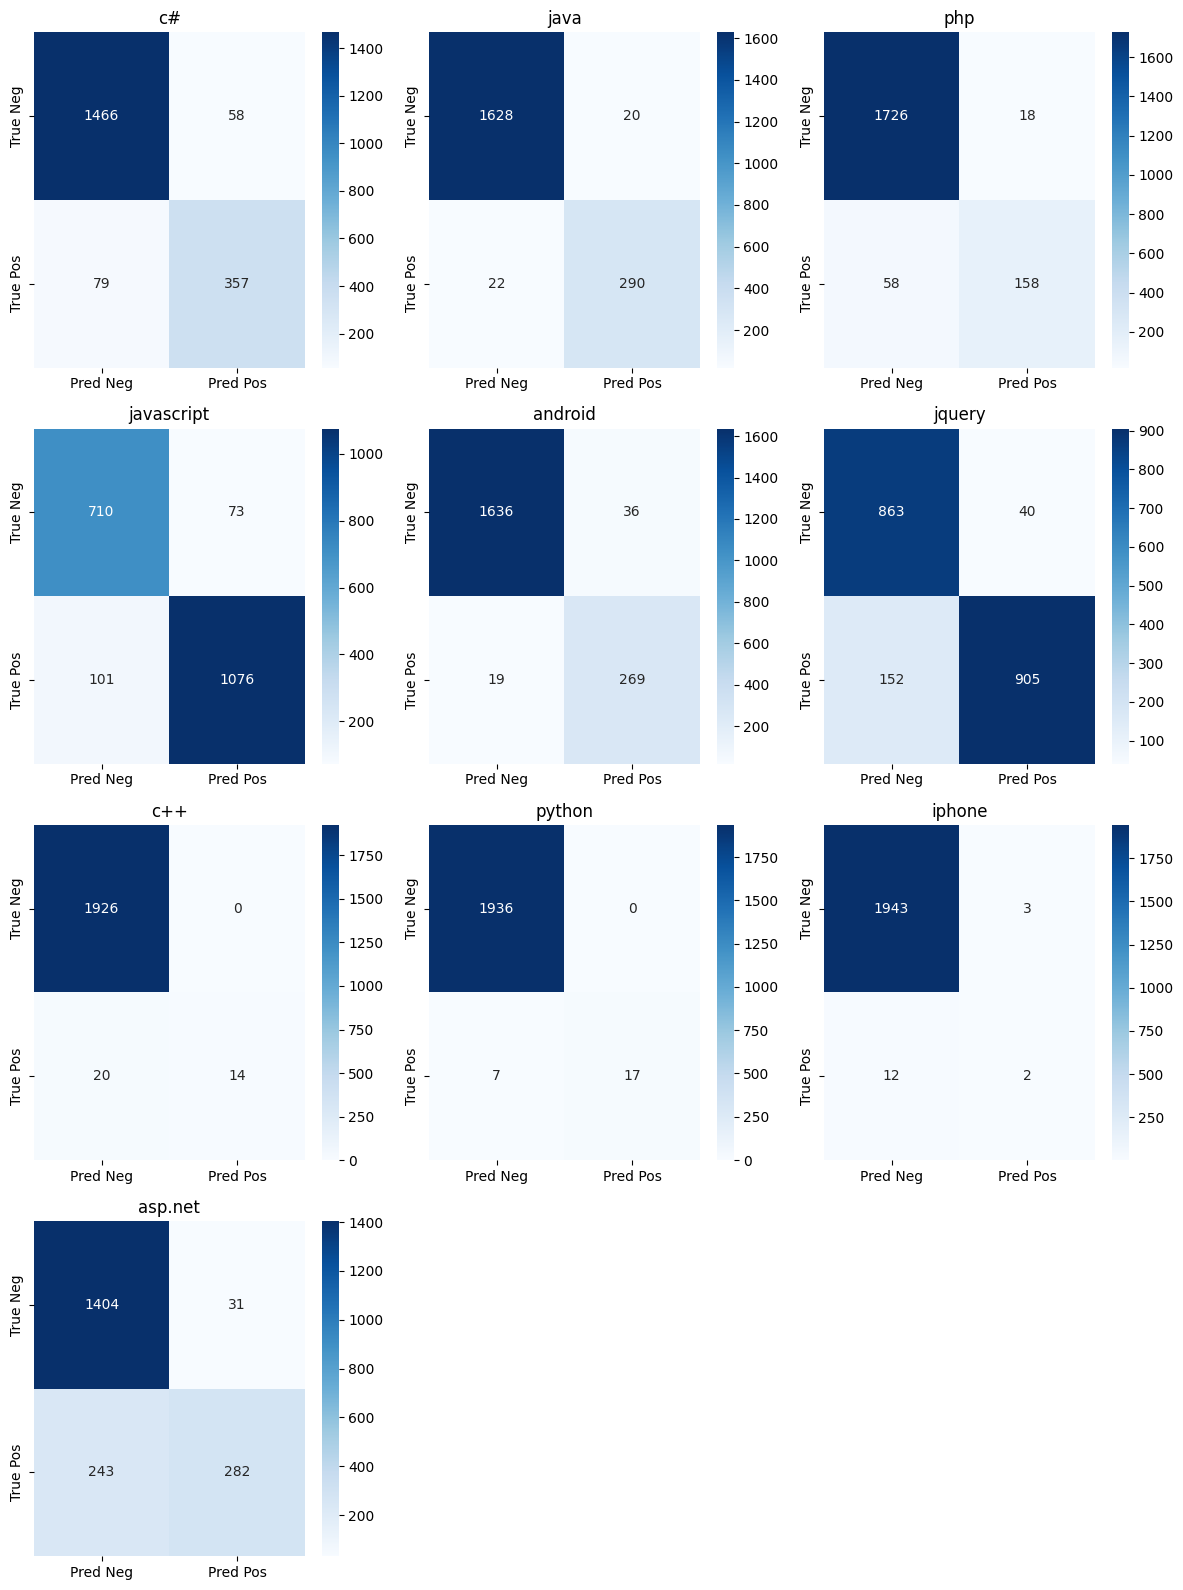

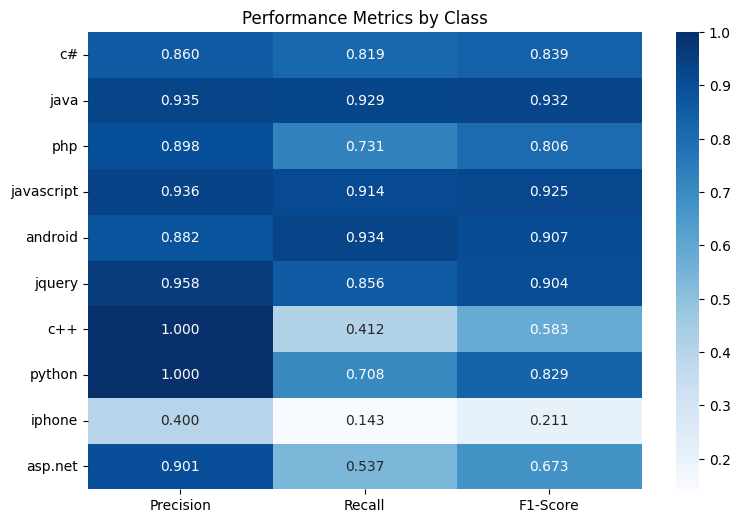

<Figure size 1200x533.333 with 0 Axes>

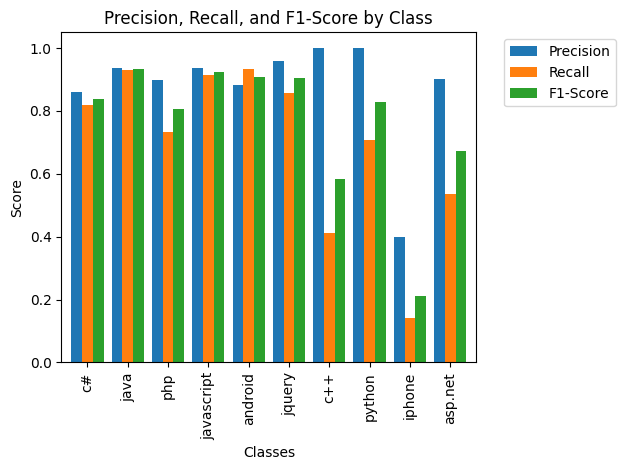

{'macro_avg': {'precision': 0.8770516237393086,
  'recall': 0.6984287215883962,
  'f1': 0.7610310861279782},
 'per_class': {'Precision': {'c#': 0.8602409638554217,
   'java': 0.9354838709677419,
   'php': 0.8977272727272727,
   'javascript': 0.9364664926022629,
   'android': 0.8819672131147541,
   'jquery': 0.9576719576719577,
   'c++': 1.0,
   'python': 1.0,
   'iphone': 0.4,
   'asp.net': 0.9009584664536742},
  'Recall': {'c#': 0.8188073394495413,
   'java': 0.9294871794871795,
   'php': 0.7314814814814815,
   'javascript': 0.9141886151231946,
   'android': 0.9340277777777778,
   'jquery': 0.8561967833491012,
   'c++': 0.4117647058823529,
   'python': 0.7083333333333334,
   'iphone': 0.14285714285714285,
   'asp.net': 0.5371428571428571},
  'F1-Score': {'c#': 0.8390129259694477,
   'java': 0.932475884244373,
   'php': 0.8061224489795918,
   'javascript': 0.9251934651762683,
   'android': 0.9072512647554806,
   'jquery': 0.9040959040959041,
   'c++': 0.5833333333333334,
   'python': 0

In [ ]:
multilabel_evaluation(y_true=valid_labels_binary, y_pred=valid_predictions_binary, class_names=class_names, figsize=(12, 8))

#  <font color = 'indianred'> **7. Performance on Test Set** </font>
For test set evaluation, we will perfrom following steps:



In [ ]:
test_split

Dataset({
    features: ['text', 'label', 'keep'],
    num_rows: 2000
})

In [ ]:
test_split = test_split.map(filter_fn, desc="Processing dataset")

Processing dataset:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
testset_filtered = test_split.filter(lambda x: x['keep']).remove_columns(['keep'])

Filter:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
testset_filtered

Dataset({
    features: ['text', 'label'],
    num_rows: 1957
})

In [ ]:
free_gpu_memory()

GPU memory has been freed.


In [ ]:
test_responses, test_extracted_outputs= run_inference(seed = 42,
              dataset=testset_filtered,
              model=model,
              tokenizer=tokenizer,
              per_device_batch_size=40,
              prompt_template=prompt_template,
              input_field=input_field,
              output_field=output_field,
              output_delimiter=output_delimiter)

Model device for inference: cuda:0


Generating responses: 100%|██████████| 49/49 [03:25<00:00,  4.20s/it]


In [ ]:
# Clean the labels and predictions
test_labels = [clean_and_split_labels(output['true_output'], class_names) for output in test_extracted_outputs]
test_predictions = [clean_and_split_labels(output['extracted_output'], class_names) for output in test_extracted_outputs]

# Initialize MultiLabelBinarizer with known classes
mlb = MultiLabelBinarizer(classes=class_names)
mlb.fit(class_names)  # Fit with all possible classes

# Transform the data
test_labels_binary = mlb.transform(test_labels)
test_predictions_binary = mlb.transform(test_predictions)

In [ ]:
test_results = compute_metrics(test_labels_binary , test_predictions_binary)

In [ ]:
test_results

{'f1_micro': 0.8712563204978607,
 'f1_macro': 0.7504593236243136,
 'accuracy_label': 0.9492590700051099,
 'accuracy_all': 0.6928972917731221}

In [ ]:
wandb.log({"test_f1_macro": test_results["f1_macro"]})

<font color = 'indianred'> *Confusion Matrix*</font>

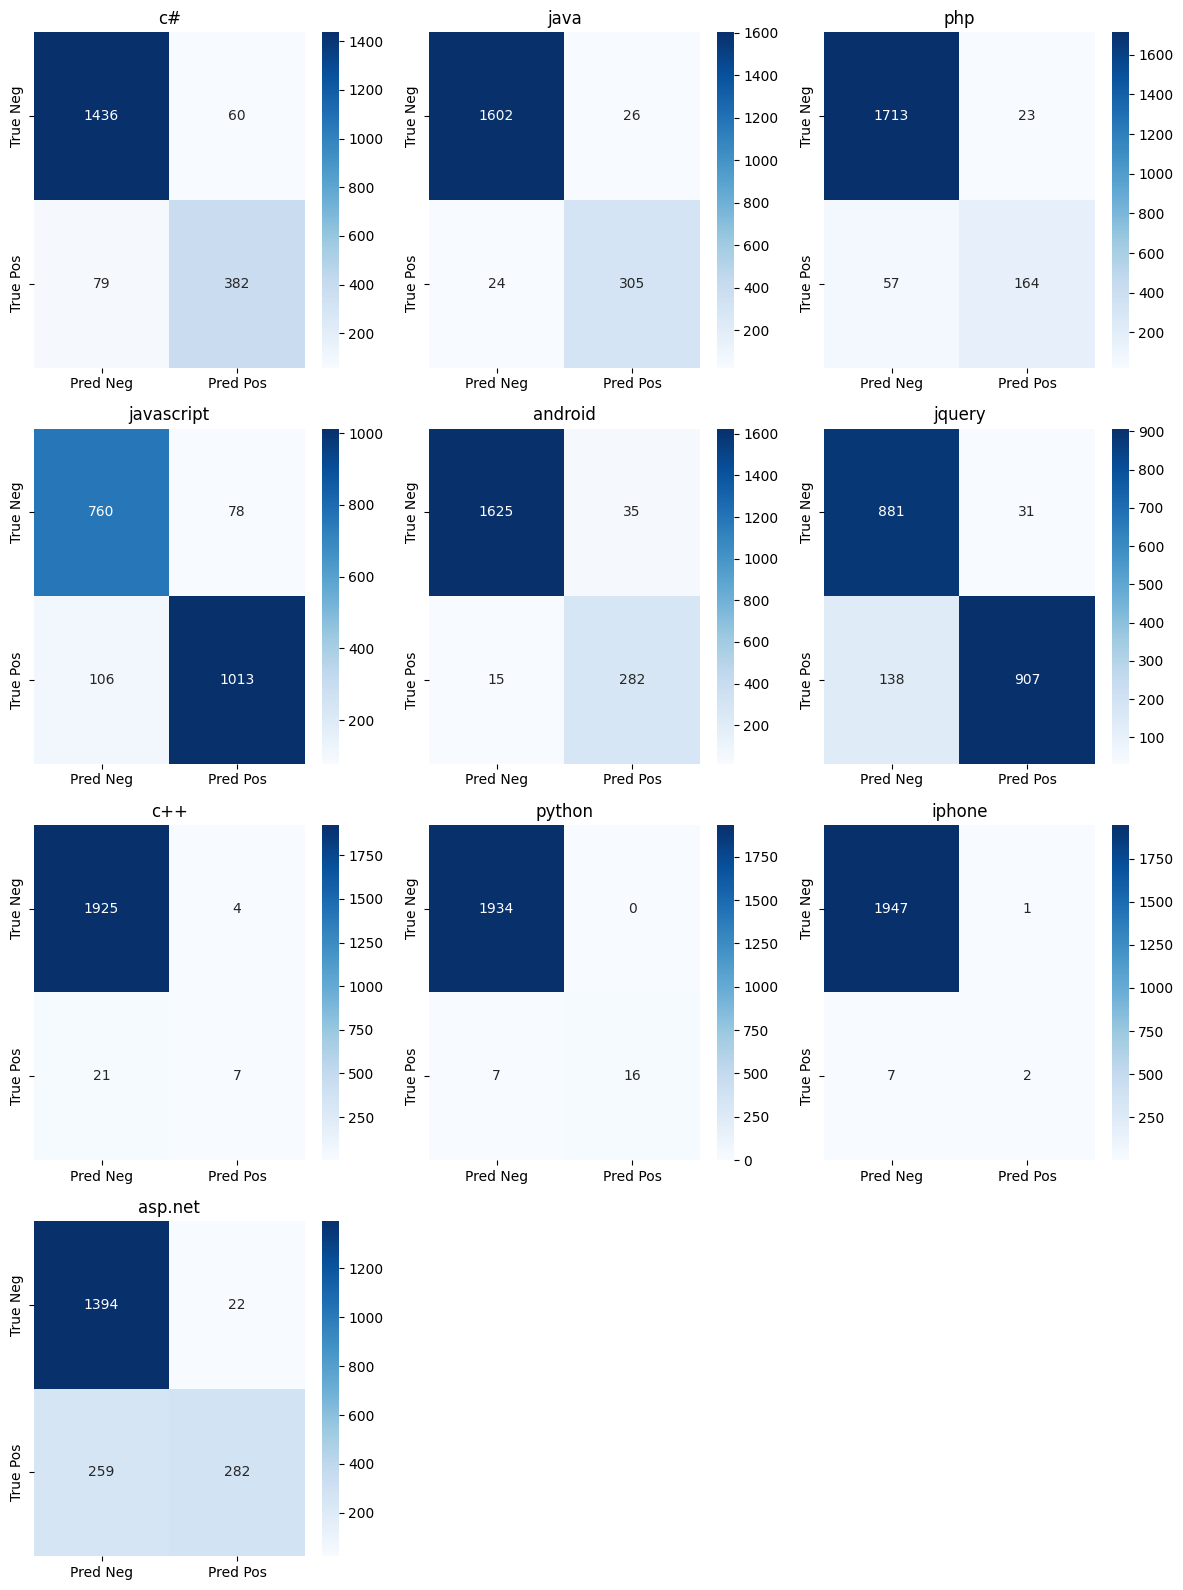

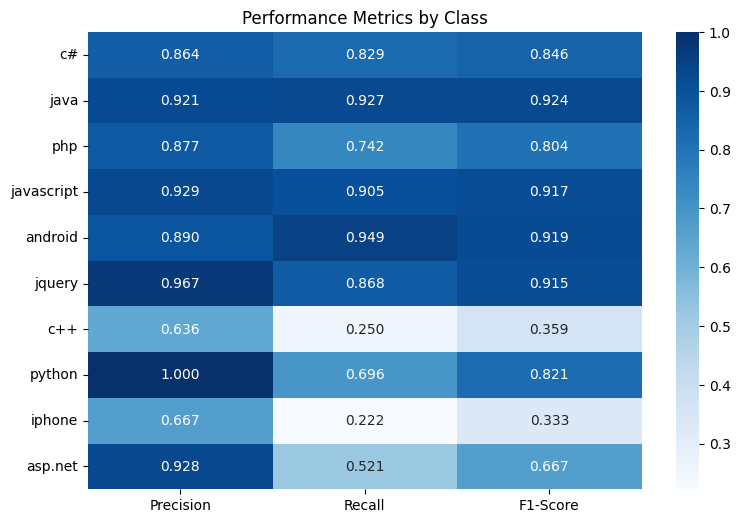

<Figure size 1200x533.333 with 0 Axes>

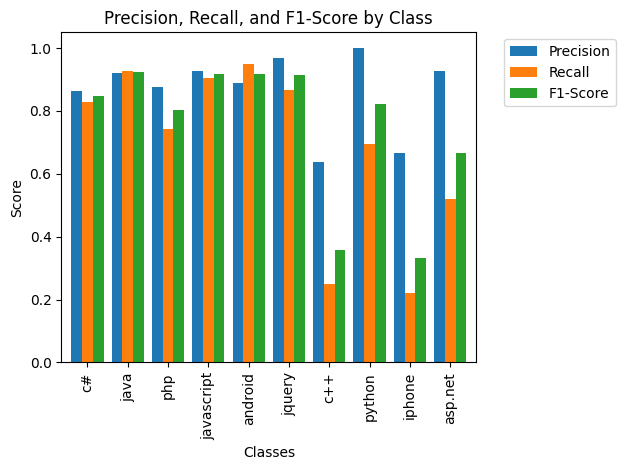

{'macro_avg': {'precision': 0.8678417596981711,
  'recall': 0.6909607951096634,
  'f1': 0.7504593236243136},
 'per_class': {'Precision': {'c#': 0.8642533936651584,
   'java': 0.9214501510574018,
   'php': 0.8770053475935828,
   'javascript': 0.928505957836847,
   'android': 0.889589905362776,
   'jquery': 0.9669509594882729,
   'c++': 0.6363636363636364,
   'python': 1.0,
   'iphone': 0.6666666666666666,
   'asp.net': 0.9276315789473685},
  'Recall': {'c#': 0.8286334056399133,
   'java': 0.9270516717325228,
   'php': 0.7420814479638009,
   'javascript': 0.9052725647899911,
   'android': 0.9494949494949495,
   'jquery': 0.8679425837320575,
   'c++': 0.25,
   'python': 0.6956521739130435,
   'iphone': 0.2222222222222222,
   'asp.net': 0.5212569316081331},
  'F1-Score': {'c#': 0.8460686600221484,
   'java': 0.9242424242424242,
   'php': 0.803921568627451,
   'javascript': 0.9167420814479638,
   'android': 0.9185667752442996,
   'jquery': 0.9147755925365607,
   'c++': 0.358974358974359,
  

In [ ]:
multilabel_evaluation(y_true=test_labels_binary, y_pred=test_predictions_binary, class_names=class_names, figsize=(12, 8))

In [ ]:
wandb.finish()

eval/loss,█▃▂▂▁▁
eval/runtime,▃▅▁█▄▇
eval/samples_per_second,▆▄█▁▅▂
eval/steps_per_second,▆▄█▁▅▂
test_f1_macro,▁
train/epoch,▁▁▂▂▄▄▅▅▆▆███
train/global_step,▁▁▂▂▄▄▅▅▆▆█████
train/grad_norm,█▃▃▁▃▄
train/learning_rate,█▇▅▄▂▁
train/loss,█▃▂▁▁▁
valid_f1_macro,▁


# <Font color = 'indianred'> **8. Model Inference**



In [ ]:
model_folder = base_folder/'models/gemma_qlora_lmh'
checkpoint = str(model_folder/f'checkpoint-{best_model_checkpoint_step}')
model = AutoPeftModelForCausalLM.from_pretrained(checkpoint,
                                             quantization_config=bnb_config,
                                             torch_dtype=torch_data_type,
                                             trust_remote_code=True,
                                             device_map='auto')
peft_config = PeftConfig.from_pretrained(checkpoint)
base_model_name = peft_config.base_model_name_or_path
tokenizer = AutoTokenizer.from_pretrained(base_model_name)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
_, extracted_outputs= run_inference(seed = 42,
              dataset=testset_filtered[0:10],
              model=model,
              tokenizer=tokenizer,
              per_device_batch_size=40,
              prompt_template=prompt_template,
              input_field=input_field,
              output_field=output_field,
              output_delimiter=output_delimiter)

Model device for inference: cuda:0


Generating responses: 100%|██████████| 1/1 [00:02<00:00,  2.28s/it]


In [ ]:
test_predictions = [clean_and_split_labels(output['extracted_output'], class_names) for output in extracted_outputs]

In [ ]:
test_predictions

[['java', 'android'],
 ['java', 'android'],
 ['php', 'javascript'],
 ['c#', 'asp.net'],
 ['javascript', 'asp.net'],
 ['javascript', 'jquery'],
 ['javascript', 'jquery'],
 ['java', 'android'],
 ['php', 'javascript'],
 ['c#']]